# Future Ecological Index plots
- Plot future ecological index
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- October 2024

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import colors as c
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load grid and mask data

### Load regional masks
- WS = Weddell Sea
- PB = East Antarctic - Prydz Bay
- DU = East Antarctic - D'Urville
- RS = Ross Sea
- AS = Amundsen Sea
- AP = Antarctic Peninsula

Get these from both the CCAMLR mask file and the story regions

In [2]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [3]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

In [4]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [5]:
# Read in "story regions"
file_in = 'antarctic_polygons/antarctic_polygon_areas_v3.nc'
ds_stories= xr.open_mfdataset(dir_in+file_in,decode_times=False)

In [6]:
# make region_list
region_list = ['Weddell', 'Prydz', 'DUrville', 'Ross', 'Amundsen', 'Peninsula']

In [7]:
# keep masks for regions of interest
WS_region = ds_ccamlr.mpa_plan_3
PB_region = ds_stories.story_prydz
DU_region = ds_stories.story_durville
RS_region = ds_stories.story_ross
AS_region = ds_stories.story_amundsen
AP_region = ds_ccamlr.mpa_plan_1

In [8]:
# concatenate into a single mask array for easier use

region_masks = xr.concat([WS_region, PB_region, DU_region,
                          RS_region, AS_region, AP_region],
                         dim='region')
region_masks['region'] = region_list

### Load shapefiles

In [9]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [10]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

## Plot figures

In [11]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_4/'

In [12]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [13]:
# get colony distance info for plotting
lons = ds_stories.TLONG
lats = ds_stories.TLAT

### Set plotting ranges for mask

In [14]:
# set contour levels
levels_in_ctr = np.arange(0,3,1)

### Plot regions

In [17]:
fout = 'Figure_4_Ecoindex_regional_map'
# get data to plot
data_plt = region_masks.fillna(0)

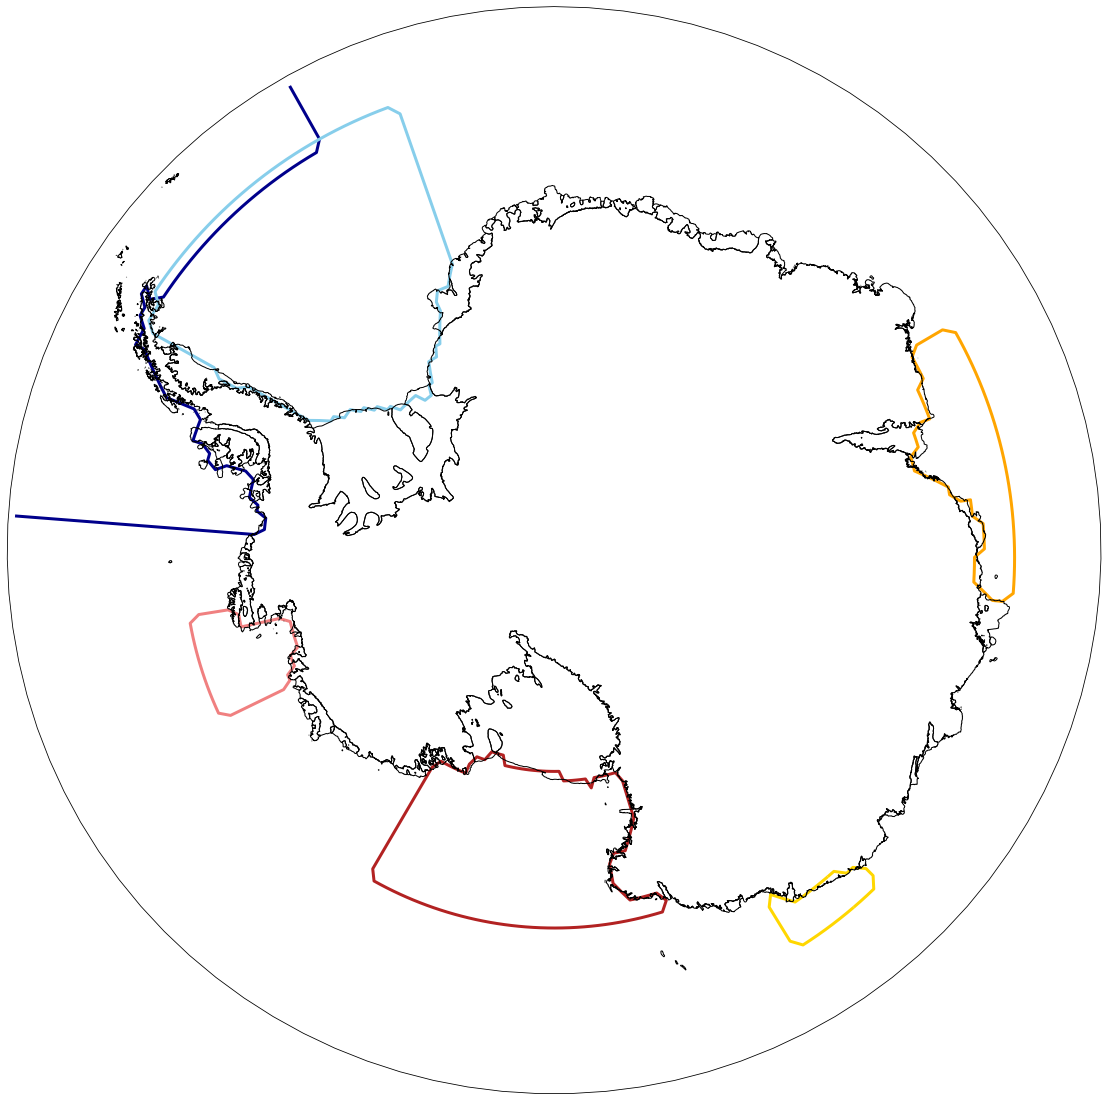

In [20]:
# create figure
fig = plt.figure(figsize=(20,20))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot regions
reg = 'Peninsula'
color = 'darkblue'
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_plt.sel(region=reg))
this1=ax.contour(lon,lat,field,
                 colors=color,linestyles='solid',linewidths=3,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
reg = 'Weddell'
color = 'skyblue'
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_plt.sel(region=reg))
this1=ax.contour(lon,lat,field,
                 colors=color,linestyles='solid',linewidths=3,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
reg = 'Prydz'
color = 'orange'
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_plt.sel(region=reg))
this1=ax.contour(lon,lat,field,
                 colors=color,linestyles='solid',linewidths=3,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
reg = 'DUrville'
color = 'gold'
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_plt.sel(region=reg))
this1=ax.contour(lon,lat,field,
                 colors=color,linestyles='solid',linewidths=3,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
reg = 'Ross'
color = 'firebrick'
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_plt.sel(region=reg))
this1=ax.contour(lon,lat,field,
                 colors=color,linestyles='solid',linewidths=3,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
reg = 'Amundsen'
color = 'lightcoral'
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_plt.sel(region=reg))
this1=ax.contour(lon,lat,field,
                 colors=color,linestyles='solid',linewidths=3,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=100)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)